## 📦 Import Libraries
This section imports essential Python libraries for data analysis, visualization, preprocessing, model building, and evaluation:
- `pandas`, `numpy`: Data manipulation and numerical operations
- `matplotlib`, `seaborn`: Data visualization
- `scikit-learn`: ML models and utilities (encoding, splitting, metrics, etc.)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

## 📁 Load Dataset
In this step, we load the training and testing datasets of the UNSW-NB15 dataset, which contains labeled network traffic data for normal and attack scenarios.


In [ ]:
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

## 🔍 Exploratory Data Analysis (EDA)
We define a function to explore datasets. It displays:
- The shape of the dataset
- Column names and data types
- Number of missing values
- Summary statistics

This helps identify inconsistencies and gives an overview of the data.


In [ ]:
def perform_eda(data, title="Dataset"):
    print(f"=== {title} Info ===")
    print(f"Shape: {data.shape}")
    print("\nData Types:")
    print(data.dtypes)
    print("\nMissing Values:")
    print(data.isnull().sum())
    print("\nNumerical Features Description:")
    print(data.describe())

    cat_cols = data.select_dtypes(include='object').columns
    for col in cat_cols:
        print(f"\n{col} Value Counts:\n", data[col].value_counts())
        plt.figure(figsize=(10, 4))
        sns.countplot(x=col, data=data)
        plt.title(f'{col} Distribution - {title}')
        plt.xticks(rotation=45)
        plt.show()
    # Target variable distribution
    if 'label' in data.columns:
        print("\nTarget Variable Distribution:")
        print(data['label'].value_counts())
        plt.figure(figsize=(6,4))
        sns.countplot(x='label', data=data)
        plt.title('Label Distribution')
        plt.show()

=== Training Set Info ===
Shape: (175341, 45)

Data Types:
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl 

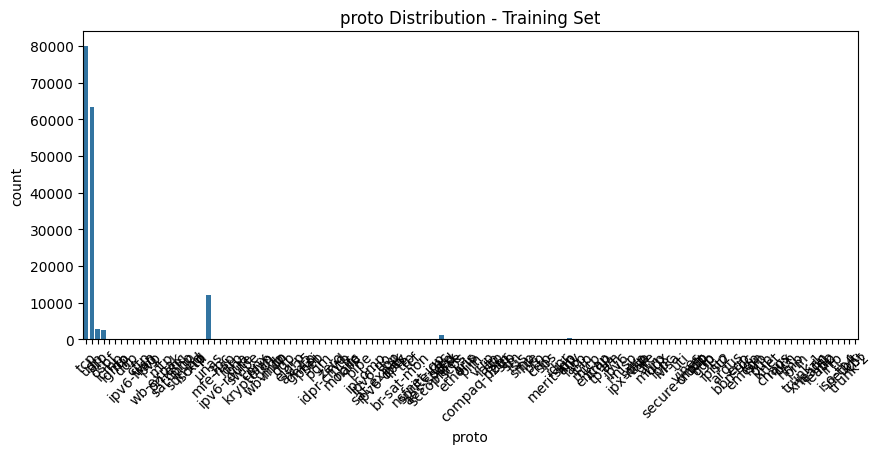


service Value Counts:
 service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64


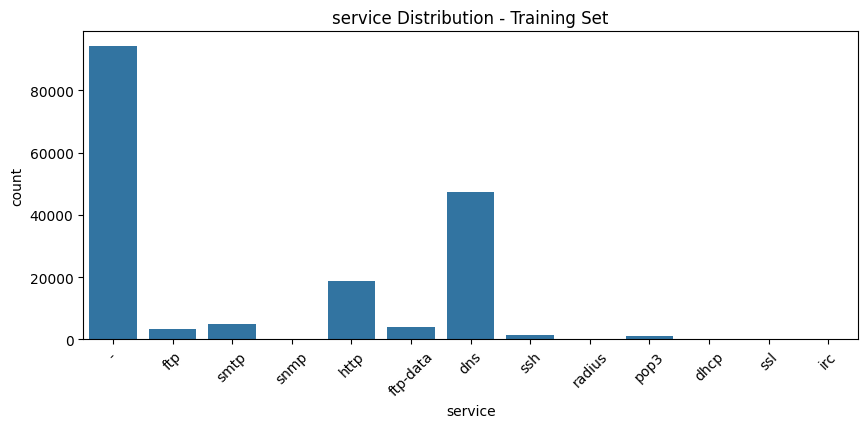


state Value Counts:
 state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64


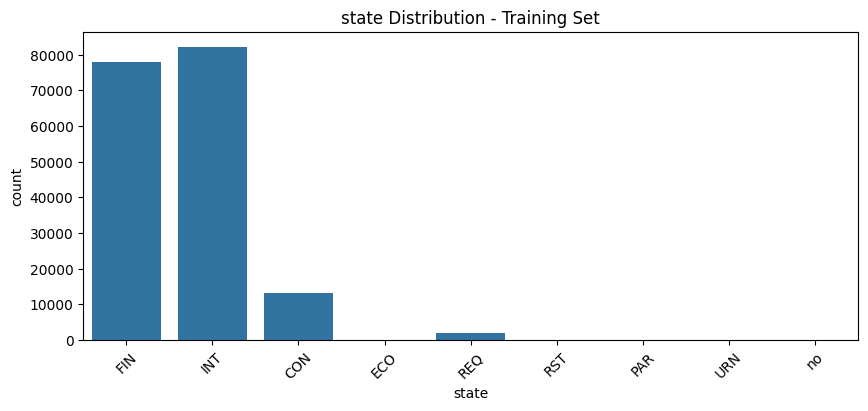


attack_cat Value Counts:
 attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


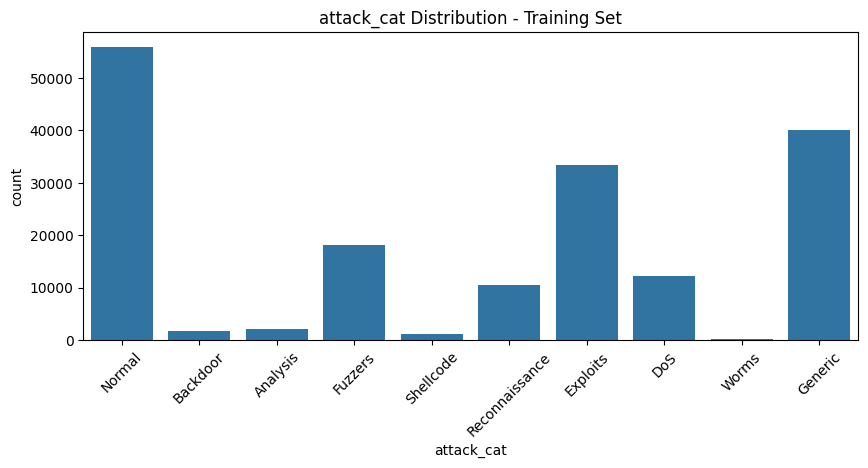


Target Variable Distribution:
label
1    119341
0     56000
Name: count, dtype: int64


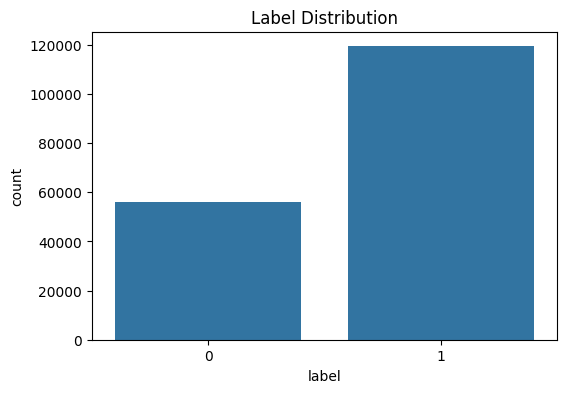

In [ ]:
perform_eda(train_data, title="Training Set")

=== Testing Set Info ===
Shape: (82332, 45)

Data Types:
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl   

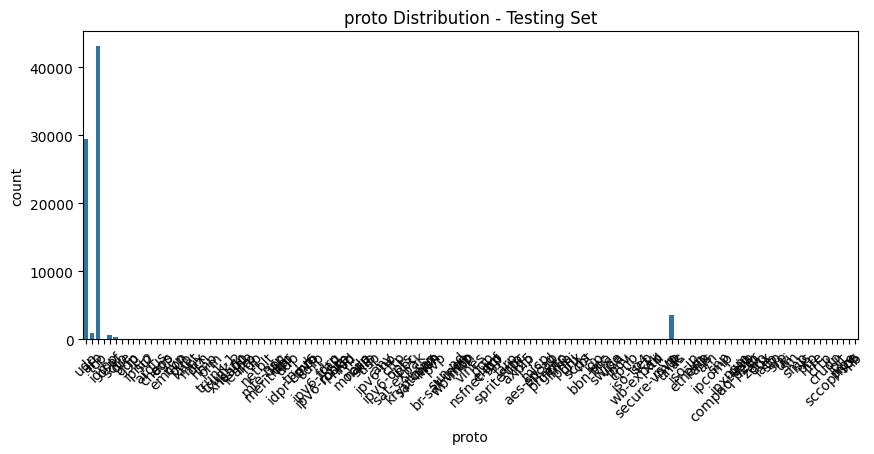


service Value Counts:
 service
-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: count, dtype: int64


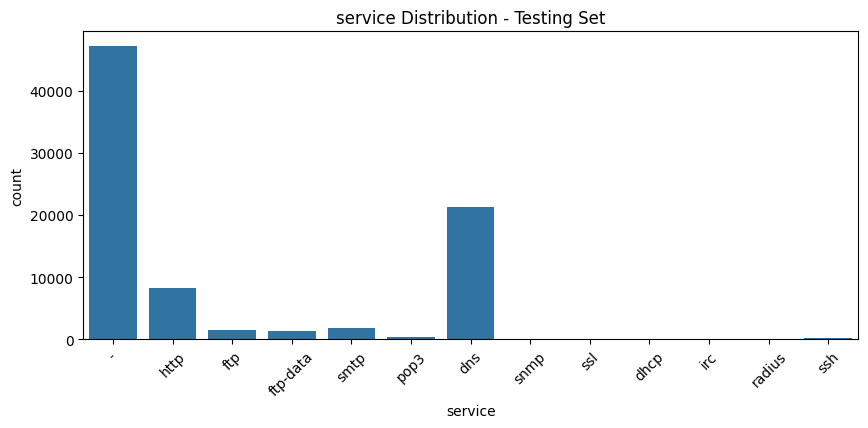


state Value Counts:
 state
FIN    39339
INT    34163
CON     6982
REQ     1842
ACC        4
RST        1
CLO        1
Name: count, dtype: int64


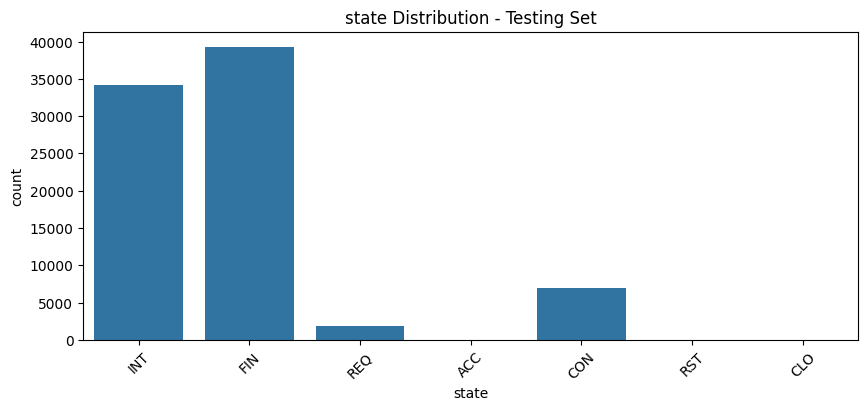


attack_cat Value Counts:
 attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


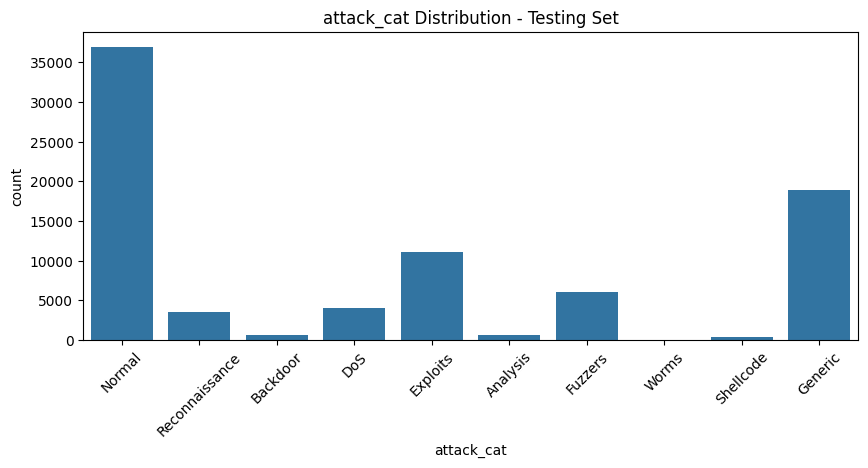


Target Variable Distribution:
label
1    45332
0    37000
Name: count, dtype: int64


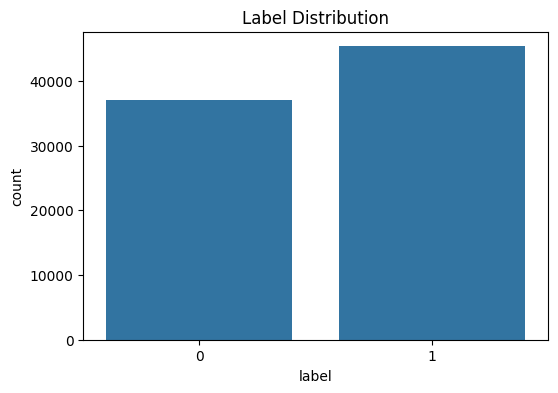

In [ ]:
perform_eda(test_data, title="Testing Set")

## ✂️ Preprocessing
This section handles:
- Dropping unnecessary or redundant columns (e.g., `id`, `attack_cat`)
- Separating features (`X`) and target labels (`y`)
- Preparing the data for encoding and scaling
## 🧼 Encoding and Scaling
We encode categorical features using  `OneHotEncoder`, and scale numeric features using `StandardScaler` to normalize data for ML models.


In [ ]:
def preprocess_data(train_df, test_df):
    # Drop unnecessary columns
    cols_to_drop = ['id', 'attack_cat']  # 'id' is redundant, 'attack_cat' is detailed label
    train_df = train_df.drop(cols_to_drop, axis=1)
    test_df = test_df.drop(cols_to_drop, axis=1)

    X_train = train_df.drop('label', axis=1)
    y_train = train_df['label']
    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label']
    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    # Identify categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns
    numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[categorical_cols])
    X_val_cat = ohe.transform(X_val[categorical_cols])
    X_test_cat = ohe.transform(X_test[categorical_cols])

    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[numerical_cols])
    X_val_num = scaler.transform(X_val[numerical_cols])
    X_test_num = scaler.transform(X_test[numerical_cols])
    # Combine features
    X_train_processed = np.concatenate([X_train_num, X_train_cat], axis=1)
    X_val_processed = np.concatenate([X_val_num, X_val_cat], axis=1)
    X_test_processed = np.concatenate([X_test_num, X_test_cat], axis=1)

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(train_data, test_data)

## 📊 Model Evaluation Function
This utility function trains and evaluates ML models and prints metrics:
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix
It simplifies consistent evaluation across all models.


In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Train model
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Metrics
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Classification reports
    print(f"\n=== {model_name} ===")
    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print("\nValidation Report:")
    print(classification_report(y_val, y_val_pred))

    print(f"\nTest Accuracy: {test_acc:.4f}")
    print("\nTest Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'{model_name} Validation')
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title(f'{model_name} Test')
    plt.tight_layout()
    plt.show()

    # ROC Curve (for models that support predict_proba)
    if hasattr(model, 'predict_proba'):
        y_val_prob = model.predict_proba(X_val)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        val_auc = roc_auc_score(y_val, y_val_prob)
        test_auc = roc_auc_score(y_test, y_test_prob)

        print(f"\nValidation AUC: {val_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")

        # Plot ROC
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

## 📈 Logistic Regression
Train and evaluate a baseline logistic regression model to classify network traffic. Logistic regression is often a good starting point for binary classification tasks.



=== Logistic Regression ===

Validation Accuracy: 0.9322

Validation Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11200
           1       0.95      0.95      0.95     23869

    accuracy                           0.93     35069
   macro avg       0.92      0.92      0.92     35069
weighted avg       0.93      0.93      0.93     35069


Test Accuracy: 0.8362

Test Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80     37000
           1       0.80      0.93      0.86     45332

    accuracy                           0.84     82332
   macro avg       0.85      0.83      0.83     82332
weighted avg       0.84      0.84      0.83     82332



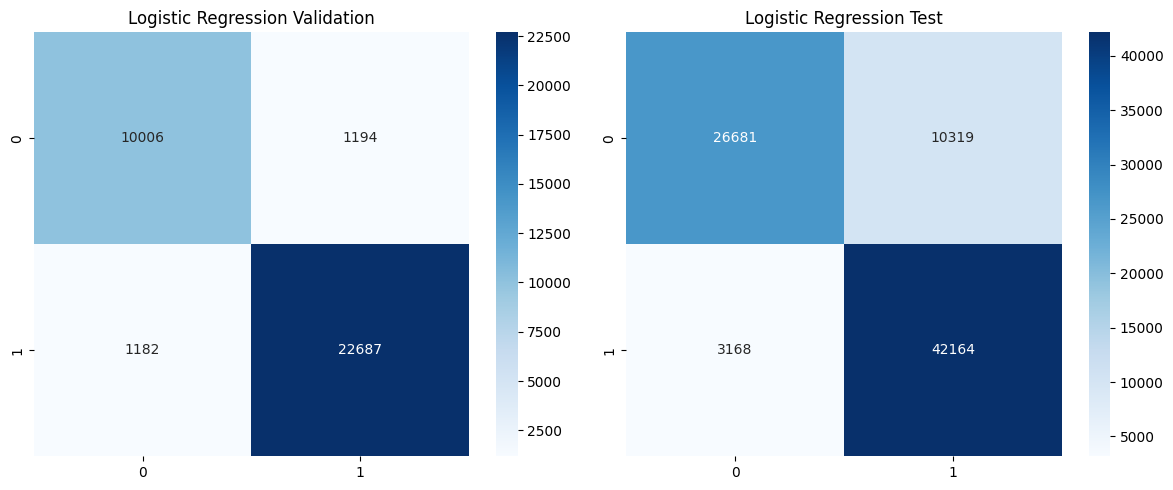


Validation AUC: 0.9844
Test AUC: 0.9557


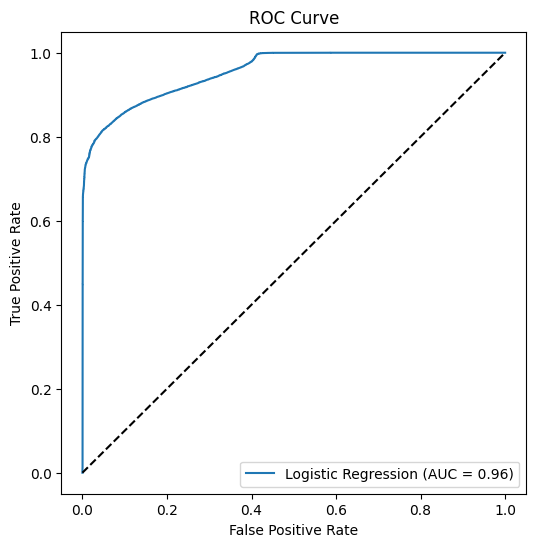

In [ ]:
lr_model = LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42)
evaluate_model(lr_model, X_train, y_train, X_val, y_val, X_test, y_test, "Logistic Regression")

## 🌳 Decision Tree
Train a Decision Tree classifier, which splits data based on feature thresholds. It can handle both categorical and numerical data.



=== Decision Tree ===

Validation Accuracy: 0.9494

Validation Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11200
           1       0.96      0.96      0.96     23869

    accuracy                           0.95     35069
   macro avg       0.94      0.94      0.94     35069
weighted avg       0.95      0.95      0.95     35069


Test Accuracy: 0.8643

Test Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     37000
           1       0.83      0.96      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.88      0.85      0.86     82332
weighted avg       0.87      0.86      0.86     82332



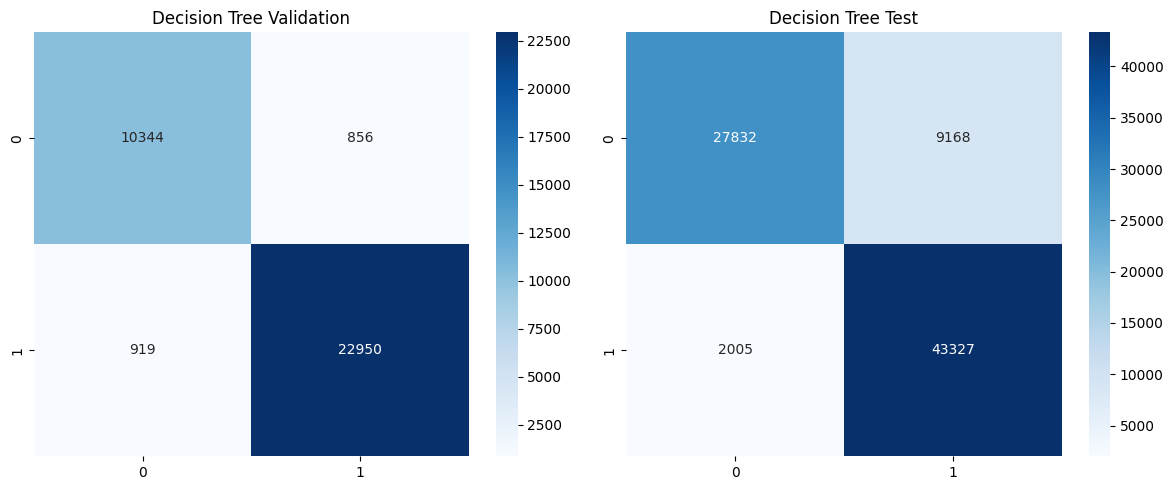


Validation AUC: 0.9436
Test AUC: 0.8562


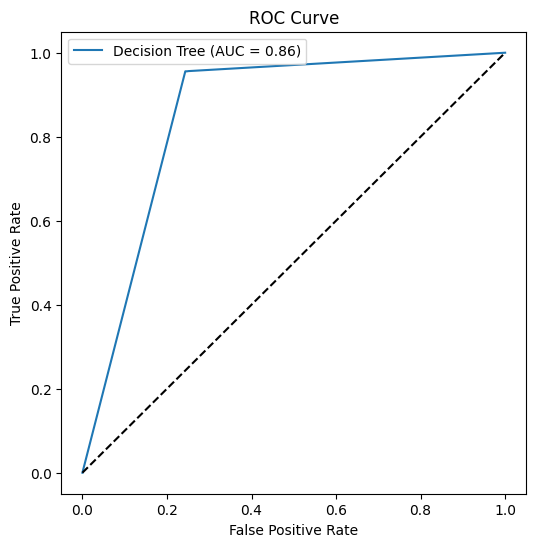

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train, y_train, X_val, y_val, X_test, y_test, "Decision Tree")

## 🌲 Random Forest
Train a Random Forest classifier, an ensemble of decision trees, for more robust and accurate predictions.



=== Random Forest ===

Validation Accuracy: 0.9592

Validation Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     11200
           1       0.96      0.98      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.96      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069


Test Accuracy: 0.8716

Test Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     37000
           1       0.82      0.99      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



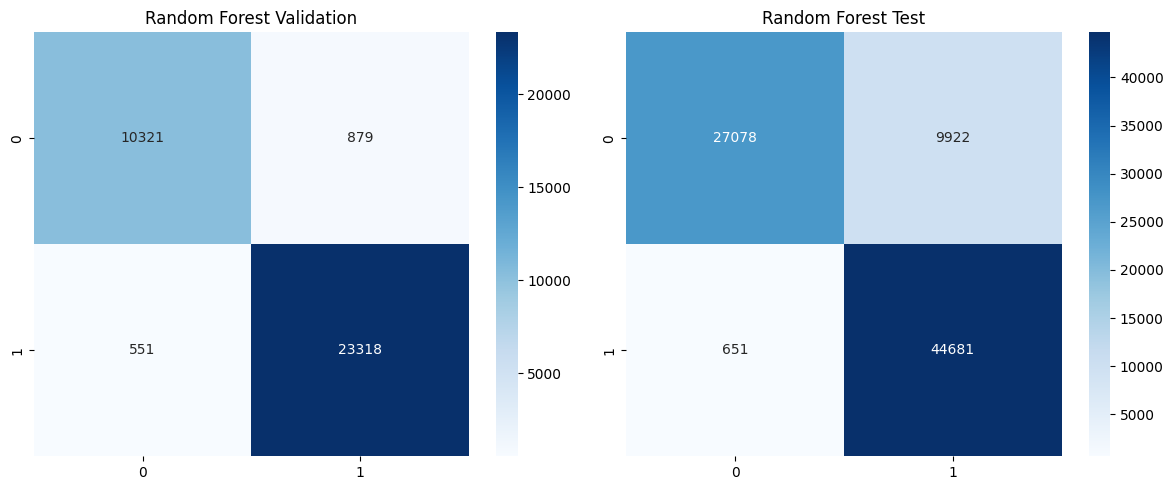


Validation AUC: 0.9936
Test AUC: 0.9790


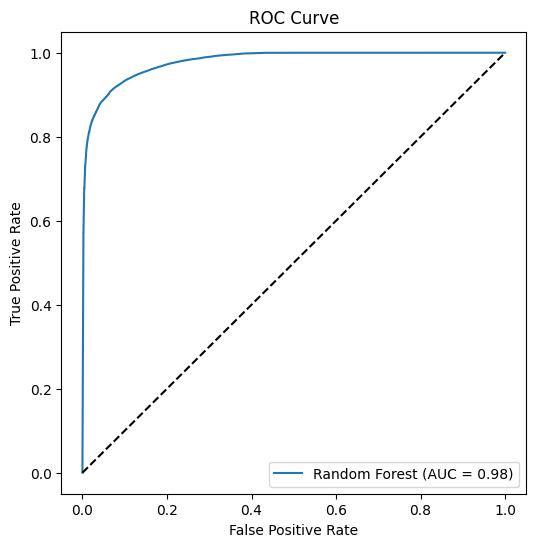

In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42)
evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, "Random Forest")

## 👣 K-Nearest Neighbors (KNN)
Train a K-Nearest Neighbors classifier to classify network traffic based on proximity to other labeled data points in the feature space. KNN is a simple yet effective non-parametric model that classifies based on majority voting among the nearest neighbors.


=== K-Nearest Neighbors ===

Validation Accuracy: 0.9387

Validation Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     11200
           1       0.95      0.96      0.96     23869

    accuracy                           0.94     35069
   macro avg       0.93      0.93      0.93     35069
weighted avg       0.94      0.94      0.94     35069


Test Accuracy: 0.8450

Test Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     37000
           1       0.80      0.96      0.87     45332

    accuracy                           0.84     82332
   macro avg       0.87      0.83      0.84     82332
weighted avg       0.86      0.84      0.84     82332



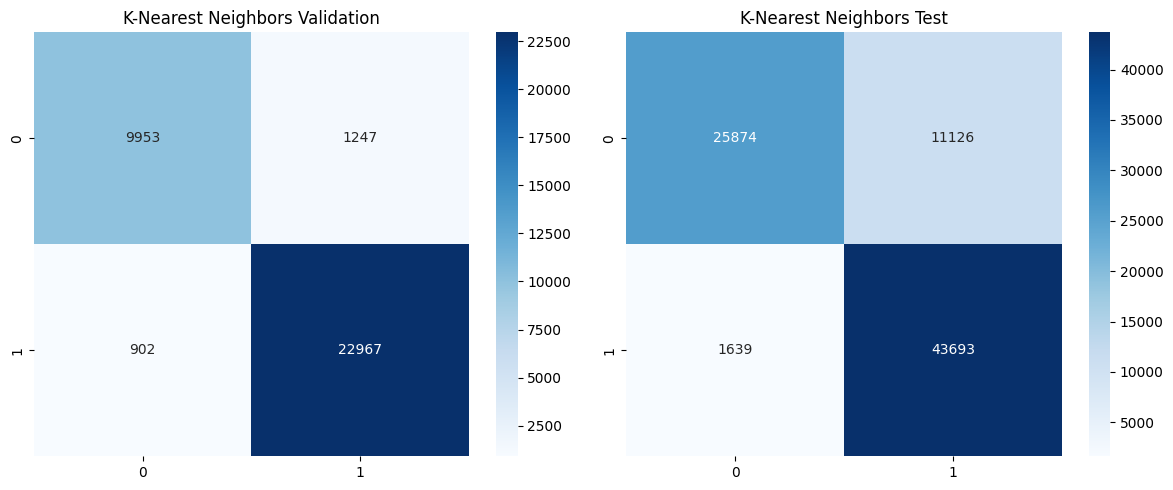


Validation AUC: 0.9764
Test AUC: 0.9318


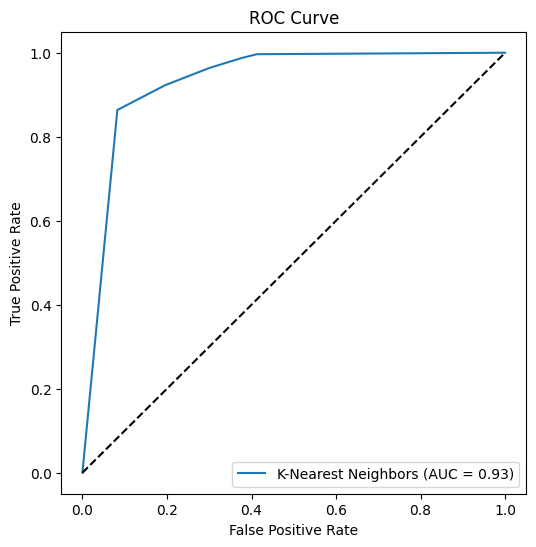

In [ ]:
knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_val, y_val, X_test, y_test, "K-Nearest Neighbors")

## 📏 Gaussian Naive Bayes (GaussianNB)
Train a Gaussian Naive Bayes classifier, which assumes that features follow a normal distribution and are conditionally independent given the class label. This probabilistic model is simple and effective, especially for high-dimensional data.


=== Naive Bayes ===

Validation Accuracy: 0.4802

Validation Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55     11200
           1       1.00      0.24      0.38     23869

    accuracy                           0.48     35069
   macro avg       0.69      0.62      0.47     35069
weighted avg       0.80      0.48      0.44     35069


Test Accuracy: 0.5562

Test Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     37000
           1       1.00      0.19      0.32     45332

    accuracy                           0.56     82332
   macro avg       0.75      0.60      0.50     82332
weighted avg       0.78      0.56      0.48     82332



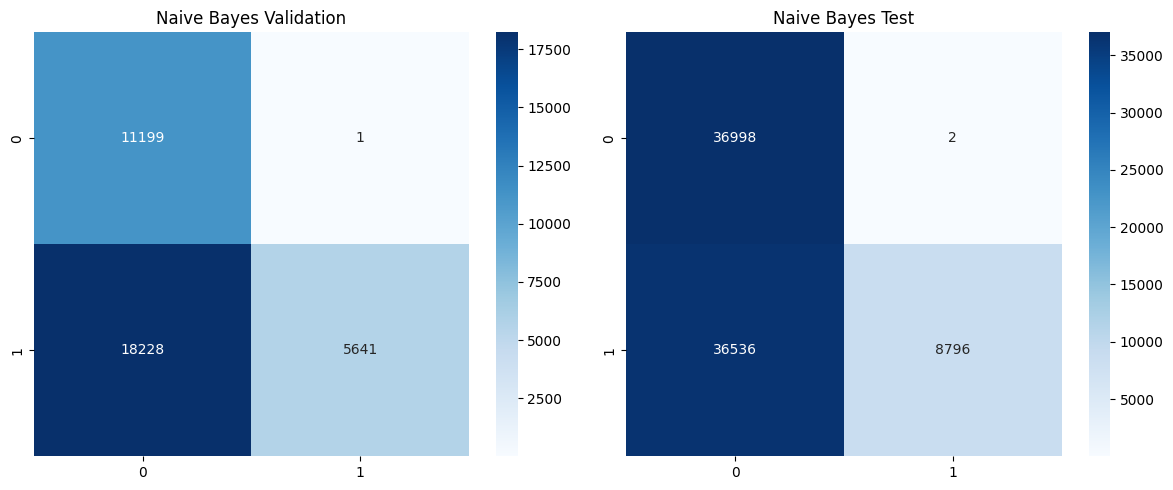


Validation AUC: 0.6875
Test AUC: 0.6891


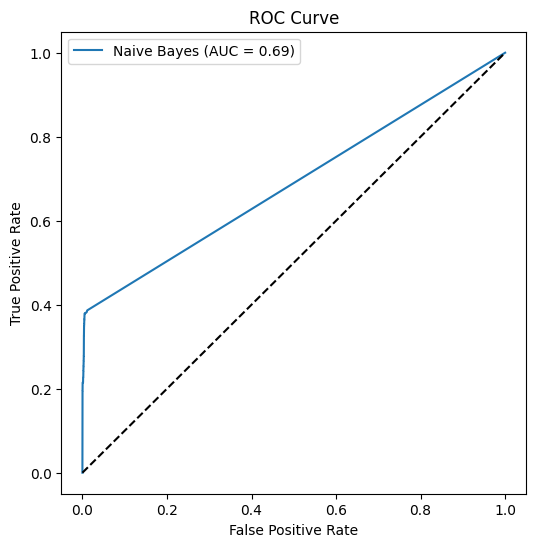

In [ ]:
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, y_train, X_val, y_val, X_test, y_test, "Naive Bayes")

## ⚙️ K-Fold Cross Validation (LR & RF)
Apply K-Fold Cross Validation to both Logistic Regression and Random Forest models for robust evaluation. It splits the data into `k` parts and trains/tests on different combinations to reduce overfitting.


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

for name, model in models.items():
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    print(f"\n=== {name} ===")
    print(f"Mean ROC AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
    print(f"Mean Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")



=== Logistic Regression ===
Mean ROC AUC: 0.9842 ± 0.0004
Mean Accuracy: 0.9319 ± 0.0019

=== Random Forest ===
Mean ROC AUC: 0.9932 ± 0.0003
Mean Accuracy: 0.9573 ± 0.0006


## ⚡ XGBoost Classifier
Train an XGBoost model, which is a powerful gradient boosting algorithm known for its performance and efficiency on structured/tabular data.


C:\Users\Mana3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===

Validation Accuracy: 0.9578

Validation Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     11200
           1       0.96      0.98      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.95      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069


Test Accuracy: 0.8736

Test Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       0.82      0.98      0.90     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



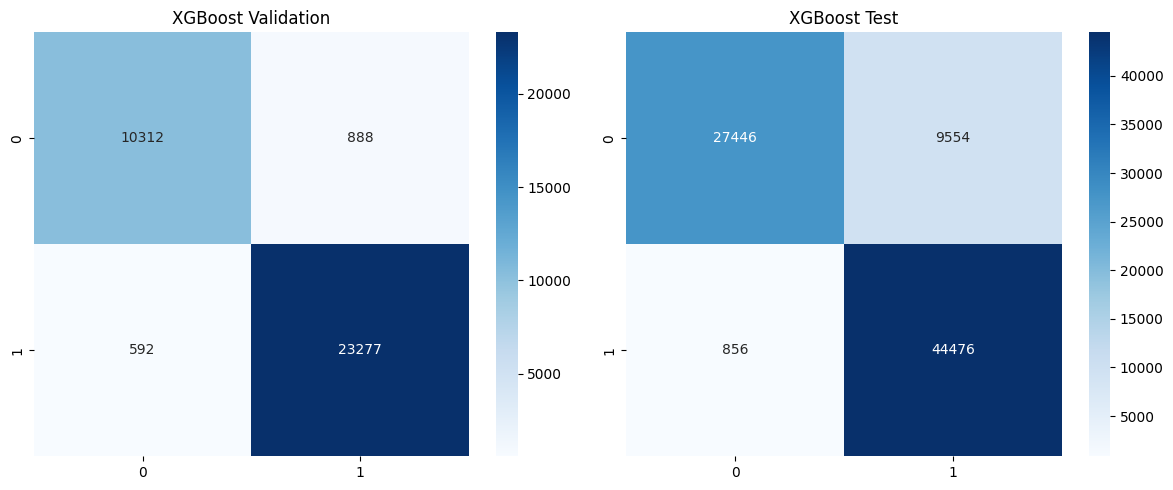


Validation AUC: 0.9936
Test AUC: 0.9830


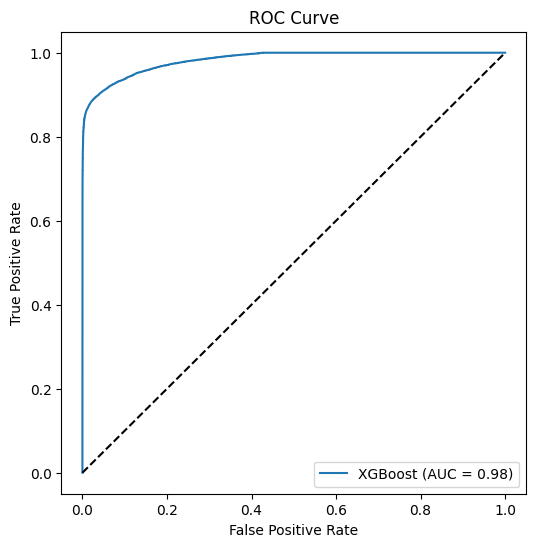

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

evaluate_model(xgb_model, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost")


## 🗳️ Voting Classifier
Apply a `VotingClassifier` to combine multiple models (Logistic Regression, Random Forest, and XGBoost) to enhance predictive performance through ensemble learning.



=== Voting Classifier ===

Validation Accuracy: 0.9594

Validation Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     11200
           1       0.96      0.98      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.96      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069


Test Accuracy: 0.8694

Test Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.89      0.87      0.87     82332



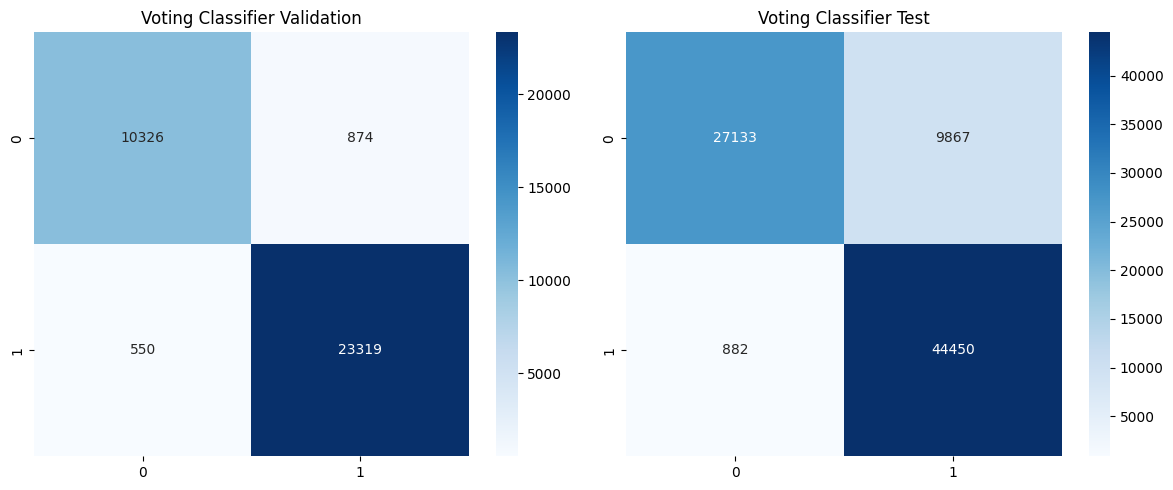


Validation AUC: 0.9934
Test AUC: 0.9791


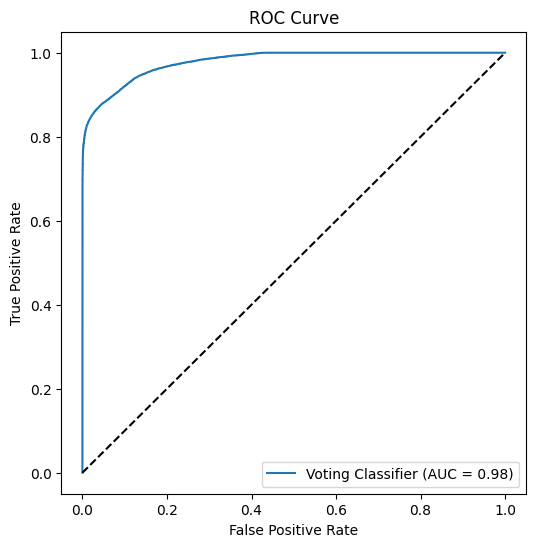

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('rf', models["Random Forest"]),
        ('xgb', xgb_model)
    ],
    voting='soft',  # soft voting gives better results for probabilistic models
    n_jobs=-1
)

# Evaluate the ensemble model
evaluate_model(voting_model, X_train, y_train, X_val, y_val, X_test, y_test, "Voting Classifier")
